# Метод К-ближайших соседей (KNN)

## Данные

Набор данных об уровнях генов. Уровени генов вычисляются как отношение между уровнем целевого гена (изучаемый ген) и уровня одного или нескольких референсных генов (как правило, уже имеющихся генов). Этот набор данных является синтетическим, и он специально был создан для того, чтобы показать сильные и слабые стороны метода KNN для классификации.

##  <span style="color:blue">Загружаем библиотеки</span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

##  <span style="color:blue">Данные</span>

In [2]:
df = pd.read_csv('gene_expression.csv')

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


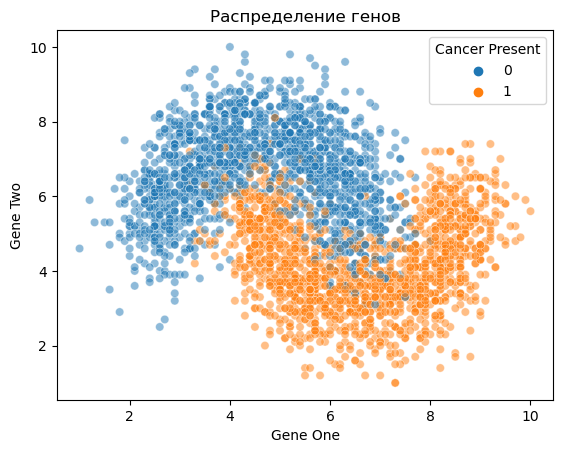

In [4]:
sns.scatterplot(data = df, 
                x = 'Gene One', 
                y = 'Gene Two', 
                hue = 'Cancer Present', 
                alpha = 0.5).set_title('Распределение генов');

Видим, что оба признака меняются в пределах от 0 до 10

Увеличим фрагмент соприкасания фрагментов

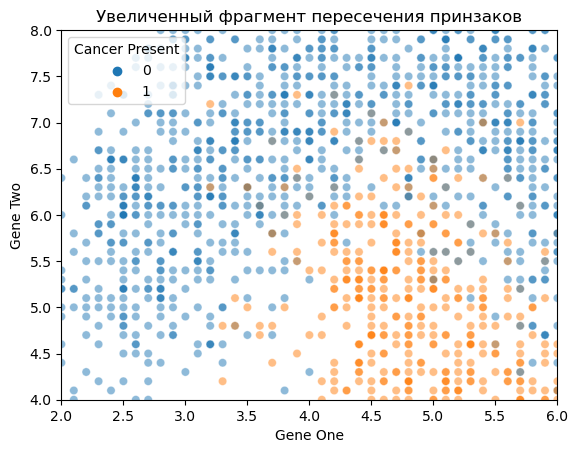

In [5]:
sns.scatterplot(data = df, 
                x = 'Gene One', 
                y = 'Gene Two', 
                hue = 'Cancer Present', 
                alpha = 0.5).set_title('Увеличенный фрагмент пересечения принзаков')
plt.xlim(2, 6)
plt.ylim(4, 8);

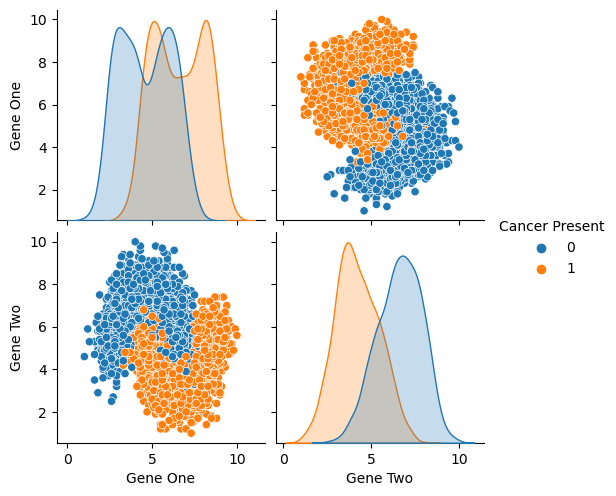

In [6]:
sns.pairplot(data = df, hue = 'Cancer Present');

Наблюдаем наличие двух модальных значений, то есть графики имеют по две вершины.
Но в целом мы видим, что два класа отделимы друг от друга

## Cоздание и обучение модели

отделям целевую переменную от признаков, разделяем на тестовый и обучающий наборы, проводим масштабирование


In [7]:
X = df.drop('Cancer Present', axis = 1)
y = df['Cancer Present']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
sc_X_train = scaler.fit_transform(X_train)
sc_X_test = scaler.transform(X_test)

Изучим, как работает модель при K = 1

In [8]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(sc_X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Оценка работы модели

In [9]:
y_pred = knn_model.predict(sc_X_test)

In [10]:
confusion_matrix(y_test, y_pred)

array([[426,  44],
       [ 45, 385]], dtype=int64)

Видим, что неправильно классифицированы 89 точек (45 + 44)
Cравнивая с размером нашей модели (900), получается, что модель ошиблась в 89 случаях из 900

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       470
           1       0.90      0.90      0.90       430

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



Precision и recall  в целом соответсвуют общей метрики accuracy для всеё модели

## Выберем оптимальное значение К с помощью метода локтя и grid search

## <span style="color:blue">Метод локтя</span>

созданим список test_error_rated для хранения ошибок, вычисленных по формуле 1 - accuracy

In [12]:
test_error_rated = []
for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=k) #создали модель
    knn_model.fit(sc_X_train, y_train) #обучение модели
    
    y_pred_test = knn_model.predict(sc_X_test) #предсказание для тестового набора данных
    
    test_error = 1 - accuracy_score(y_test, y_pred_test) #вычисление ошибки
    
    test_error_rated.append(test_error) #добавление в список

In [13]:
test_error_rated

[0.09888888888888892,
 0.09777777777777774,
 0.07333333333333336,
 0.0755555555555556,
 0.07222222222222219,
 0.06444444444444442,
 0.06444444444444442,
 0.061111111111111116,
 0.05777777777777782,
 0.06222222222222218,
 0.061111111111111116,
 0.06000000000000005,
 0.061111111111111116,
 0.06222222222222218,
 0.05888888888888888,
 0.05777777777777782,
 0.05666666666666664,
 0.05555555555555558,
 0.05222222222222217,
 0.053333333333333344,
 0.054444444444444406,
 0.05111111111111111,
 0.054444444444444406,
 0.054444444444444406,
 0.05666666666666664,
 0.05555555555555558,
 0.05555555555555558,
 0.05777777777777782,
 0.05666666666666664]

Bидим что для большинства задач увеличение приведет к уменьшению ошибок? однако в какой-то момент это уменьшение сходит на нет

Визуализация

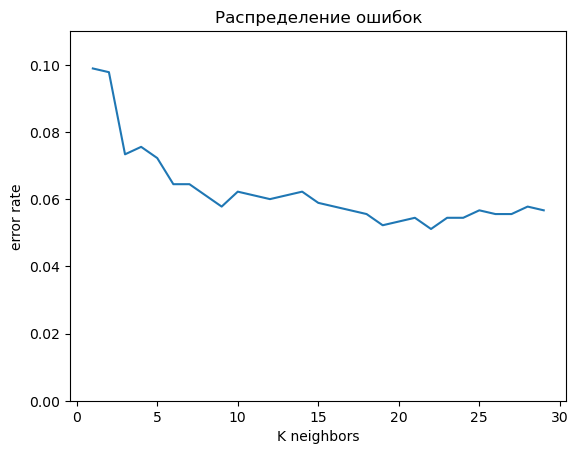

In [14]:
plt.plot(range(1, 30), test_error_rated)
plt.ylabel('error rate')
plt.xlabel('K neighbors')
plt.ylim(0, 0.11)
plt.title('Распределение ошибок');

При увеличении масштаба видно, что несмотря на то, что к = 23 не сильную разницу в размере ошибки по сравнению с к = 6, поэтому чтобы уменьшить нагрузку лучше взять меньшее значение к

## <span style="color:blue">GRIDSEARCH CV</span>

In [15]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

Узнаем название параметров, которые нужно задавать

In [16]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

Создаем список операций (где каждая операция это кортеж) по порядку: масштабирование (переменная scaler) потом создание модели (переменная knn)

In [17]:
operations = [('scaler', scaler), ('knn', knn)]

Создаем pipline, где в качестве шагов выбираем переменную operations

In [18]:
pipe = Pipeline(operations)

Подготовка к созданию сетки gridsearch cv


In [19]:
k_values = list(range(1, 20))

При создании сетки параметров, которая будет помещаться внутрь Pipline нужно создавать названия переменных по определенным правилам:
- выбранное_название_строки + два нижних подчеркивания + название ключевого параметра
- название_модели + __ + название параметра
- knn_model + __ + n_neighbors
- knn_model__n_neighbors

In [20]:
param_grid = {'knn__n_neighbors' : k_values}

Создаем gridsearch cv

In [21]:
full_cv_classifier = GridSearchCV(pipe, param_grid, cv = 5,
                                 scoring = 'accuracy')

In [22]:
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

Когда мы применяем StandardScaler в качестве шага внутри Pipeline, то scikit-learn сделает всю нужную работу следующим образом:

* Шаг 0: Данные разбиваются на обучающий и тестовый наборы данных, в соответствии с параметром cv, который Вы указали в GridSearchCV.
* Шаг 1: объект scaler выбирает нужный масштаб на обучающем наборе данных
* Шаг 2: объект scaler трансформирует обучающий набор данных
* Шаг 3: выполняется обучение модели, используя трансформированный обучающий набор данных
* Шаг 4: объект scaler применяется для трансформации тестового набора данных
* Шаг 5: обученная модель выполняет предсказания, используя трансформированный тестовый набор данных


Выведем лучшие параметры, подобранные методом gridsearch cv

In [23]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=16),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform'}

Видим что оптимальное значение knn__n_neighbors' равно 16

## Проверим работу модели на финальных данных

In [24]:
full_pred = full_cv_classifier.predict(X_test)

In [25]:
print(classification_report(y_test, full_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



Видим, что модель работает лучше, чем для K = 1, и нам также не понадобилось доходить до K = 22, которое мы увидели в методе локтя.